<a href="https://colab.research.google.com/github/GarzonDiegoINL/Characterization/blob/main/DOE_creation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create factorial DoE
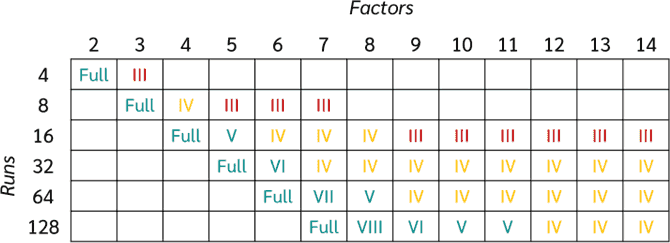

In [ ]:
!pip install dexpy

  Preparing metadata (setup.py) ... done
  Created wheel for dexpy: filename=dexpy-0.12-py3-none-any.whl size=30218 sha256=c11e90843ddddda3ff1677717bb3837324e8f829600b8ab394f3766a6da7e1ab
  Stored in directory: /root/.cache/pip/wheels/dd/8a/9e/c664d82eab1605d51db7f16b30ee38d1712f54cd2106b0c79e
Successfully built dexpy


In [ ]:
def create_DOE(n_factors, n_runs, factor_names, actual_lows, actual_highs):

  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import dexpy.factorial
  import dexpy.alias

  #Check good input
  run_factorial = False
  if n_runs % 2 != 0:
    message = 'Number of runs should be a power of 2'
  elif len(factor_names) != n_factors:
    message = 'Number of factor names should equal number of factors'
  elif len(actual_lows) != n_factors:
    message = 'Number of actual lows should equal number of factors'
  elif len(actual_highs) != n_factors:
    message = 'Number of actual highs should equal number of factors'
  elif n_runs > 2**n_factors:
    message = 'Number of runs cannot exceed 2**number of factors'
  elif n_runs == 2**n_factors:
    message = 'Running a full factorial DoE'
    run_factorial= True
  else:
    message = 'Running a partial factorial DoE'
    run_factorial = True
  print(message)

  if run_factorial:

    #build screening experiment
    exp_table = dexpy.factorial.build_factorial(n_factors,n_runs)
    exp_table.columns = factor_names

    #Create a dictionary with lows and highs
    actual_lows = {factor_names[i]: actual_lows[i] for i in range(n_factors)}
    actual_highs = {factor_names[i]: actual_highs[i] for i in range(n_factors)}


    #set the actual low and high values
    actual_design = dexpy.design.coded_to_actual(exp_table, actual_lows, actual_highs)

    #randomize the experiments
    experiment_order = actual_design.sample(frac=1).reset_index(drop=True)
    experiment_order.index += 1
    experiment_order.to_excel('DOE plan.xlsx')
    return experiment_order

In [ ]:
n_factors = 4 #Set here the number of factors
n_runs = 8 #Set here the number of runs, which will determine if it will be full or fractional factorial

factor_names = ['power',
                'gas',
                'frequency',
                'annealing_temperature']

low_limits = [100,
              25,
              0.2,
              300]

high_limits = [300,
               85,
               0.8,
               600]

create_DOE(n_factors, n_runs, factor_names, low_limits, high_limits)

Running a partial factorial DoE


power   gas  frequency  annealing_temperature
1  100.0  85.0        0.2                  600.0
2  100.0  85.0        0.8                  300.0
3  300.0  25.0        0.8                  300.0
4  100.0  25.0        0.8                  600.0
5  300.0  25.0        0.2                  600.0
6  300.0  85.0        0.8                  600.0
7  100.0  25.0        0.2                  300.0
8  300.0  85.0        0.2                  300.0

# Analyze DoE - Ordinary Least Squares (OLS)

In [ ]:
def analyze_DOE_OLS(excel_file, order=1, target_column='target', plot=True):
  import pandas as pd
  import numpy as np
  import itertools

  df = pd.read_excel(excel_file)
  if 'Unnamed: 0' in df.columns:
    df = df.drop(columns='Unnamed: 0')
  elif 'Run Order' in df.columns:
    df = df.drop(columns='Run Order')

  target_column = target_column.lower()
  display(df)

  import re
  df.columns = df.columns.map(lambda x: re.sub('\s+', '_', x.lower().strip()))

  #Fix that the target can have also spaces
  target_column = re.sub('\s+', '_', target_column.lower().strip())

  columns = df.drop(columns=target_column).columns

  eq = "("+" + ".join(columns)+")**" + str(order)

  print("Ordinary Least Squares Fitting")
  import statsmodels.formula.api as smf
  lm = smf.ols(target_column + " ~ " + eq, data = df).fit()
  print(target_column + " ~ " + eq)
  print(lm.summary2())

  with open('OLS ouput.txt', 'w') as f:
    f.write(lm.summary2().as_text())


  if plot:
    #1 dimensional plots
    print('Plotting 1 dimensional')
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set_context('paper')

    pp = sns.pairplot(data=df,
                  y_vars=[target_column],
                  x_vars=columns)
    plt.suptitle('1D plots')
    plt.savefig('1D plots - OLS analysis of DoE.png')
    plt.show()

    #2 dimensional plots
    print('Plotting 2 dimensional')
    px = sns.pairplot(data=df, hue=target_column)
    plt.suptitle('2D plots')
    plt.savefig('2D plots - OLS analysis of DoE.png')
    plt.show()

from google.colab import files
import pandas as pd
import io

def upload_and_read_file():
  """Uploads a file in Colab and reads it into a pandas DataFrame."""
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

  return fn

In [ ]:
uploaded_file = upload_and_read_file()
if uploaded_file is not None:
   print("\nSuccessfully uploaded and read the file.")

Saving DOE plan (5).xlsx to DOE plan (5).xlsx
User uploaded file "DOE plan (5).xlsx" with length 8919 bytes

Successfully uploaded and read the file.


power  gas  frequency  annealing_temperature  Columbic efficiency
0    100   85        0.2                    600             3.981596
1    100   85        0.8                    300             0.267585
2    300   25        0.8                    300             9.040212
3    100   25        0.8                    600             1.352132
4    300   25        0.2                    600           134.515930
5    300   85        0.8                    600           119.304928
6    100   25        0.2                    300             0.301701
7    300   85        0.2                    300            26.620528

Ordinary Least Squares Fitting
columbic_efficiency ~ (power + gas + frequency + annealing_temperature)**2
                      Results: Ordinary least squares
Model:                 OLS                   Adj. R-squared:       nan      
Dependent Variable:    columbic_efficiency   AIC:                  -388.5439
Date:                  2025-07-25 14:53      BIC:                  -387.9084
No. Observations:      8                     Log-Likelihood:       202.27   
Df Model:              7                     F-statistic:          nan      
Df Residuals:          0                     Prob (F-statistic):   nan      
R-squared:             1.000                 Scale:                inf      
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        0.0088      inf  0.0000   nan    nan 

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning:

invalid value encountered in scalar multiply



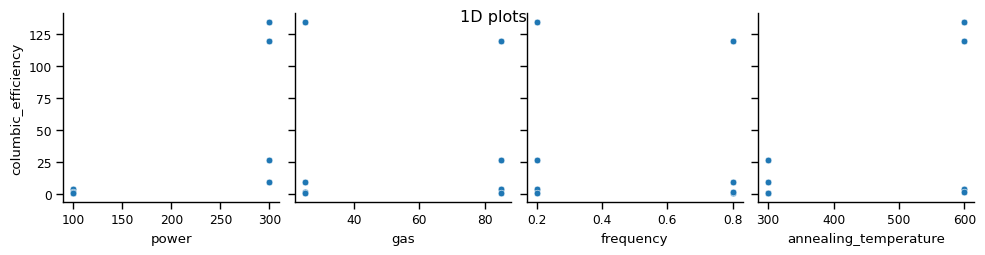

Plotting 2 dimensional


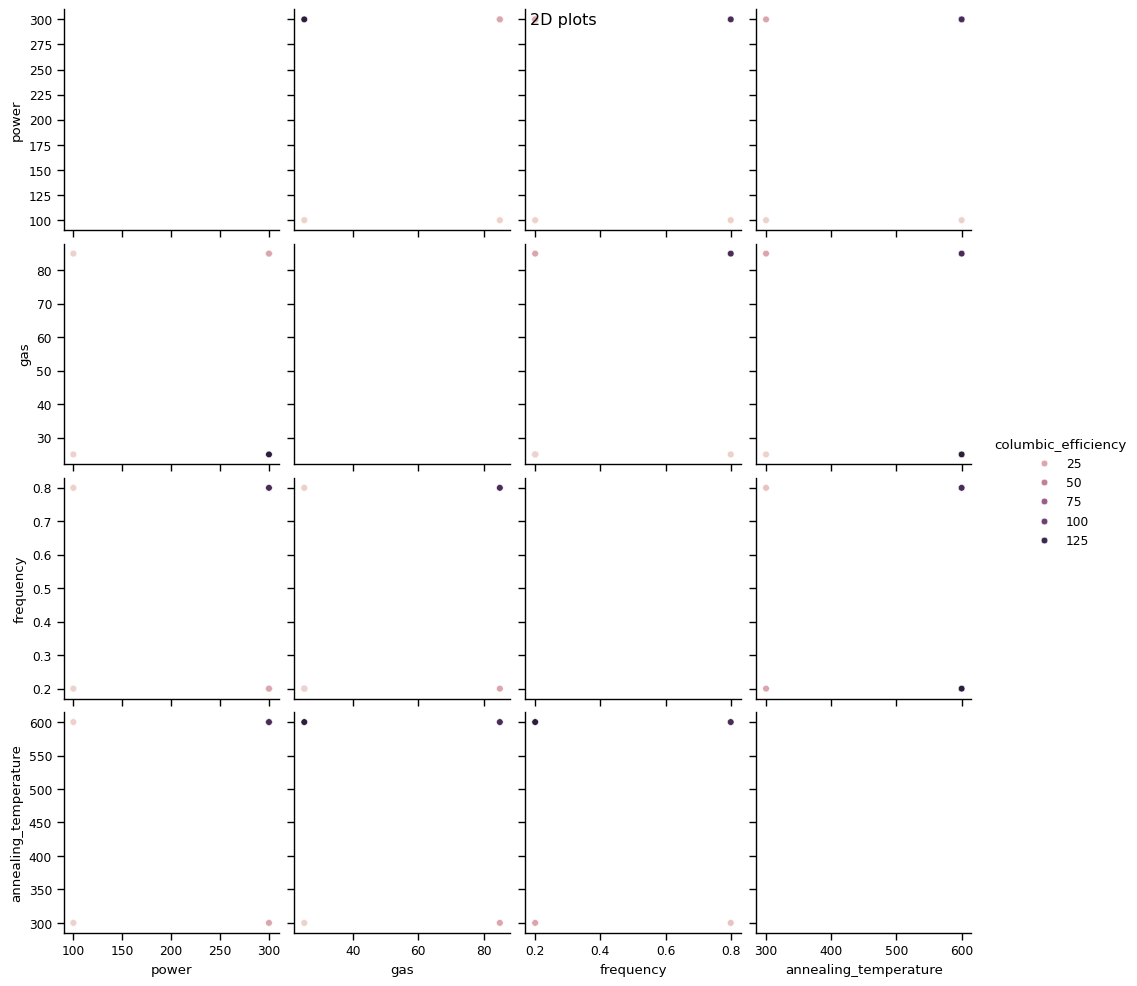

In [ ]:
analyze_DOE_OLS(uploaded_file, 2, 'Columbic efficiency')

# Analyze DoE - Bayesian Optimization (BO)

We are installing Ax here ...

In [1]:
pip install -U kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

in_colab = 'google.colab' in sys.modules
if in_colab:
    %pip install ax-platform --quiet --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.9/779.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

... and then loading all required submodules.

In [3]:
from ax.utils.notebook.plotting import init_notebook_plotting, render
import plotly.io as pio

init_notebook_plotting()
if in_colab:
    pio.renderers.default = "colab"

[WARNING 08-19 02:05:41] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


[INFO 08-19 02:05:41] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 08-19 02:05:41] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


We are using the "**Service API**" of Ax, which is only one of multiple ways of using Ax.

More information can be found on the [Ax website](https://ax.dev/docs/tutorials/gpei_hartmann_service/).

In [62]:
from logging import error
def get_data_from_excel(excel_file, answer_column='target', error_column='error', n_trials = 5, experiment_name = 'test', objective='Max', plot=True):
  import pandas as pd
  import itertools
  import plotly.graph_objects as go
  import re

  from ax.service.ax_client import AxClient, ObjectiveProperties
  from ax.generation_strategy.generation_strategy import GenerationStep, GenerationStrategy
  from ax.adapter.registry import Generators


  df = pd.read_excel(excel_file, dtype='float')
  if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

  parameters = [] #List of dictionaries with the parameters

  if not isinstance(answer_column, list):
    answer_column = [answer_column]

  if not isinstance(error_column, list):
    error_column = [error_column]

  if len(answer_column) != len(error_column) or error_column[0] not in df.columns:
    print('Error answer list and error list should be the same size, an analysis without considering the error will be performed')
    no_error = True
  else:
    no_error = False

  if no_error:
    cols_to_append = df.drop(columns=answer_column).columns.to_list()
  else:
    cols_to_append = df.drop(columns=answer_column+error_column).columns.to_list()


  for col in cols_to_append:
    parameters.append({'name': col,
                       'type': 'range',
                       'bounds': [df[col].min(), df[col].max()],
                       'value_type': 'float'
                       })

  #Create strategy
  gs = GenerationStrategy(steps=[
        #GenerationStep(Generators.SOBOL, num_trials=5),
        GenerationStep((Generators.BOTORCH_MODULAR), num_trials=n_trials)])

  ax_client_own = AxClient(generation_strategy = gs)

  ax_client_own.create_experiment(name=experiment_name,
                                    parameters = parameters,
                                    objectives = {re.sub(r'\s+', '_', col): ObjectiveProperties(minimize=False) for col in answer_column})


  for idx in df.index:
    parameterization, trial_index = ax_client_own.attach_trial(
        parameters={re.sub(r'\s+', '_', col): df.loc[idx, col] for col in cols_to_append}
    )
    if no_error:
      ax_client_own.complete_trial(trial_index=trial_index, raw_data={re.sub(r'\s+', '_', col): (df.loc[idx, col], 0) for col in answer_column})
    else:
      ax_client_own.complete_trial(trial_index=trial_index, raw_data={re.sub(r'\s+', '_', col): (df.loc[idx, col], df.loc[idx, error_col]) for col, error_col in zip(answer_column, error_column)})

  for n_trials_remaining in range(n_trials):
    parameterization, trial_index = ax_client_own.get_next_trial()

  df_results = ax_client_own.experiment.to_df()

  df_results.to_excel('Bayesian optimization output.xlsx')
  display(df_results)

  if len(answer_column) <= 1:
    best_parameters, prediction = ax_client_own.get_best_parameters()
    print("Best Parameters:", best_parameters)
    print("Prediction (mean, variance):", prediction)
  else:
    best_parameters= ax_client_own.get_pareto_optimal_parameters()
    print("Best Parameters:", best_parameters)


  if plot:
    for answer in answer_column:
      answer = re.sub(r'\s+', '_', answer)
      for par1, par2 in list(itertools.combinations(parameters, 2)):
            plot_config = ax_client_own.get_contour_plot(param_x=par1['name'], param_y=par2['name'], metric_name=answer)
            render(plot_config)
            # Convert AxPlotConfig to plotly figure and save
            fig = go.Figure(data=plot_config.data)
            fig.write_image(f"contour_plot_{answer}_{par1['name']}_{par2['name']}.png")



  return df_results

from google.colab import files
import pandas as pd
import io

def upload_and_read_file():
  """Uploads a file in Colab and reads it into a pandas DataFrame."""
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

  return fn

In [63]:
uploaded_file = upload_and_read_file()
if uploaded_file is not None:
   print("\nSuccessfully uploaded and read the file.")

Saving analysis Jsc Voc FF.xlsx to analysis Jsc Voc FF.xlsx
User uploaded file "analysis Jsc Voc FF.xlsx" with length 11056 bytes

Successfully uploaded and read the file.


In [64]:
df_results = get_data_from_excel(uploaded_file,
                                 answer_column=['Mean JSC', 'Mean FF', 'Mean VOC'],
                                 n_trials=5,
                                 error_column=['Std. Dev Jsc', 'Std. Dev FF', 'Std. Dev Voc'],
                                 )

[WARNING 08-19 03:09:53] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-19 03:09:53] ax.service.ax_client: Completed trial 0 with data: {'Mean_JSC': (np.float64(23.993708), np.float64(1.932007)), 'Mean_FF': (np.float64(42.434672), np.float64(7.504584)), 'Mean_VOC': (np.float64(0.404965), np.float64(0.062788))}.
[INFO 08-19 03:09:53] ax.service.ax_client: Completed trial 1 with data: {'Mean_JSC': (np.float64(18.495983), np.float64(5.051462)), 'Mean_FF': (np.float64(27.806112), np.float64(3.823663)), 'Mean_VOC': (np.float64(0.27145), np.float64(0.028356))}.
[INFO 08-19 03:09:53] ax.service.ax_client: Completed trial 2 with data: {'Mean_JSC': (np.float64(13.596813), np.float64(5.014725)), 'Mean_FF': (np.float64(29.828072), np.float64(2.753055)), 'Mean_VOC': (np.float64(0.30915), np.float64(0.066187))}.
[INFO 08-19 03:09:53] ax.service.ax_client: Completed tr

trial_index arm_name trial_status   generation_node   Mean_JSC    Mean_FF  \
0             0      0_0    COMPLETED              None  23.993708  42.434672   
1             1      1_0    COMPLETED              None  18.495983  27.806112   
2             2      2_0    COMPLETED              None  13.596813  29.828072   
3             3      3_0    COMPLETED              None  13.244960  27.889557   
4             4      4_0    COMPLETED              None  21.031170  32.502300   
5             5      5_0    COMPLETED              None  28.464596  55.332428   
6             6      6_0    COMPLETED              None  21.612987  34.396600   
7             7      7_0    COMPLETED              None   4.646385  26.234207   
8             8      8_0    COMPLETED              None  26.531452  53.758076   
9             9      9_0      RUNNING  GenerationStep_0        NaN        NaN   
10           10     10_0      RUNNING  GenerationStep_0        NaN        NaN   
11           11     11_0      RUNNING  GenerationStep_0        NaN        NaN   
12           12     12_0      RUNNING  GenerationStep_0        NaN        NaN   
13           13     13_0      RUNNING  GenerationStep_0        NaN        NaN   

    Mean_VOC      EA+TEA      NH4OH   Cations        TTZ  
0   0.404965  112.000000  13.000000  5.000000  10.000000  
1   0.271450  210.000000  13.000000  5.000000  20.000000  
2   0.309150  112.000000  25.000000  5.000000  20.000000  
3   0.092656  210.000000  25.000000  5.000000  10.000000  
4   0.228675  112.000000  13.000000  9.400000  20.000000  
5   0.530026  210.000000  13.000000  9.400000  10.000000  
6   0.272221  112.000000  25.000000  9.400000  10.000000  
7   0.249336  210.000000  25.000000  9.400000  20.000000  
8   0.547482  168.000000  20.000000  7.500000  20.000000  
9        NaN  201.797716  13.916569  9.020001  11.314654  
10       NaN  210.000000  14.605558  9.400000  10.000000  
11       NaN  159.643210  19.206226  6.580190  20.000000  
12       NaN  210.000000  13.000000  8.135264  10.000000  
13       NaN  197.812702  14.068259  8.651046  10.303970

[INFO 08-19 03:10:15] ax.service.utils.best_point: Using inferred objective thresholds: [ObjectiveThreshold(Mean_FF >= 50.97886394086436), ObjectiveThreshold(Mean_JSC >= 26.883207081588044), ObjectiveThreshold(Mean_VOC >= 0.5054603070529937)], as objective thresholds were not specified as part of the optimization configuration on the experiment.


Best Parameters: OrderedDict([(5, ({'EA+TEA': 210.0, 'NH4OH': 13.0, 'Cations': 9.4, 'TTZ': 10.0}, ({'Mean_FF': np.float64(52.566860869037995), 'Mean_JSC': np.float64(27.751488693331435), 'Mean_VOC': np.float64(0.5257465042566984)}, {'Mean_FF': {'Mean_FF': 17.48778677946206, 'Mean_JSC': 0.0, 'Mean_VOC': 0.0}, 'Mean_JSC': {'Mean_FF': 0.0, 'Mean_JSC': 4.385622318077019, 'Mean_VOC': 0.0}, 'Mean_VOC': {'Mean_FF': 0.0, 'Mean_JSC': 0.0, 'Mean_VOC': 0.00042925224775079755}})))])
